In [ ]:
"""
initial test case where obstacles are placed above and below wrt robot
"""

In [2]:
import numpy as np 
from parameters import Parameters
from mobility_functions import Mobility_Functions
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
# Disable scientific notation
np.set_printoptions(suppress=True)



def velocity_robot(t, r_d, param: Parameters, mobility_fun: Mobility_Functions) -> np.ndarray:
    
    param.position_robot = r_d
    dimen_distance = (2 * param.distance_cal) / (param.radius_obstacle + param.radius_robot)
    mobility_fun.dimensionless_distance = dimen_distance
    inter_act = interactions(mobility_fun, param)
    U_stokes = param.Force / (6 * np.pi *0.1 * param.radius_robot)
    del_U = np.dot(param.Force, inter_act) - U_stokes
    
    return U_stokes + del_U.sum(axis=0)


def interactions(mobility_fun: Mobility_Functions, param: Parameters) -> np.ndarray:
    return b_alp_beta(mobility_fun.A11, mobility_fun.B11, param) - (b_alp_beta(mobility_fun.A12, mobility_fun.B12, param) \
                        @ b_alp_beta(mobility_fun.A21, mobility_fun.B21, param)) \
                        @ np.linalg.inv(b_alp_beta(mobility_fun.A22, mobility_fun.B22, param))
    

def broad_cast(shape_array: np.ndarray, reshape_array) -> np.ndarray:
    return np.broadcast_to(shape_array[:, np.newaxis, np.newaxis], reshape_array.shape)

def b_alp_beta(A: np.ndarray, B: np.ndarray, param: Parameters):
    
    const = 1 / ( 3 * np.pi * param.viscosity * (param.radius_robot + param.radius_obstacle))
    
    A_alp_beta = broad_cast(A,param.outer_product) * param.outer_product /\
    np.power(param.distance_cal.reshape((param.position_array.shape[0], 1, 1)), 2)
    
    B_alp_beta = broad_cast(B, param.outer_product) * (param.unit_tensor_mat - param.outer_product /\
    np.power(param.distance_cal.reshape((param.position_array.shape[0], 1, 1)), 2))

    return const * (A_alp_beta + B_alp_beta)
# 
a_d = 5
a_o = 5
r_d = np.array([10, 50,10])
r_o = np.array([[20, 40, 20], [40, 60, 10], [60, 40, 5], [80, 60, 20], [100, 60, 10], [120, 40, 5], [150, 60, 20], [190, 60, 10]]) 
# r_o = np.array([[20, 40, 20], [40, 60, 40], [60, 40], [80, 60], [100, 60], [120, 40], [150, 60], [190, 60]]) 
F = np.array([0.005,0,0])
r = r_o - r_d 
param = Parameters(viscosity=0.1, radius_robot=a_d, radius_obstacle=a_o, position_robot=r_d, position_obstacle=r_o, Force=F)
s = 2 * param.distance_cal / (a_o + a_d)
la = np.tile( [a_o / a_d], (s.shape[0]))
mob_fun = Mobility_Functions(dimensionless_distance=s, lamda=la)
vel=[]
inter = interactions(mob_fun, param)
vel = velocity_robot(0 ,r_d, param, mob_fun)
U_stokes = param.Force / (6 *np.pi *0.1* 5)
U_robo_magn = np.linalg.norm(vel,ord=2,axis=0)
tspan = (0,6_00_000)
t_eval = np.arange(0,6_00_000,1)

traje = solve_ivp(velocity_robot, tspan, r_d, method='RK45', t_eval=t_eval, args=(param, mob_fun))
# if __name__ == 'main.py': 
#     main()

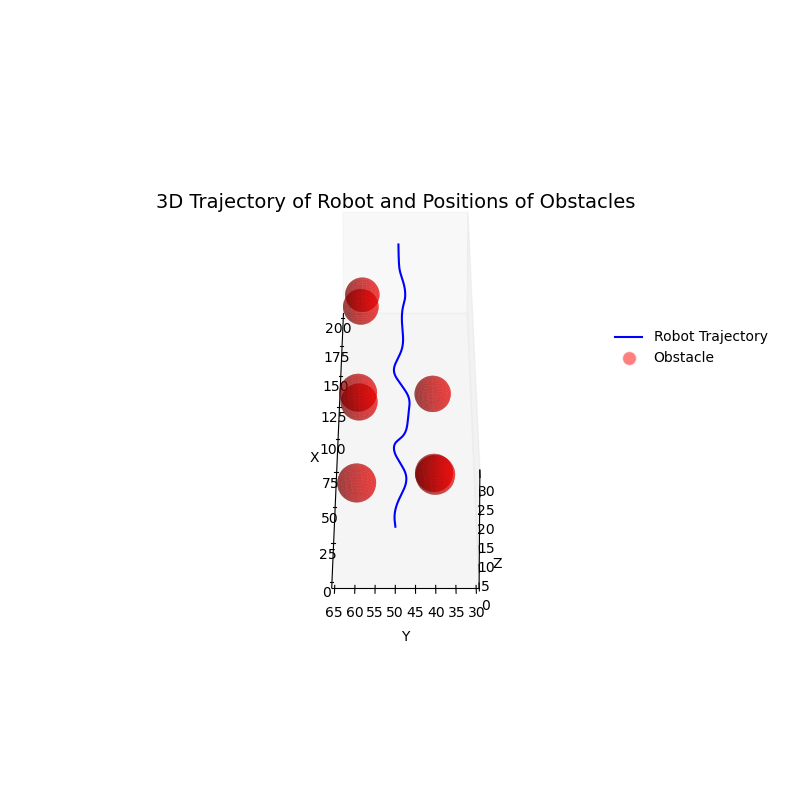

In [26]:
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
# import numpy as np

# def set_axes_equal(ax):
#     '''Make the aspect ratio of the 3D plot equal.'''
#     x_limits = ax.get_xlim3d()
#     y_limits = ax.get_ylim3d()
#     z_limits = ax.get_zlim3d()

#     x_range = abs(x_limits[1] - x_limits[0])
#     y_range = abs(y_limits[1] - y_limits[0])
#     z_range = abs(z_limits[1] - z_limits[0])

#     x_middle = np.mean(x_limits)
#     y_middle = np.mean(y_limits)
#     z_middle = np.mean(z_limits)

#     plot_radius = 0.5 * max([x_range, y_range, z_range])

#     ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
#     ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
#     ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


# Create a 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.gca(projection='3d')

# Plot the robot's 3D trajectory (X, Y, Z)
ax.plot(traje.y[0], traje.y[1], traje.y[2], color='blue', label='Robot Trajectory')

# Plot the obstacles as spheres
for idx, obs in enumerate(r_o):
    # Create a sphere for each obstacle
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    x = a_o * np.cos(u) * np.sin(v) + obs[0]
    y = a_o * np.sin(u) * np.sin(v) + obs[1]
    z = a_o * np.cos(v) + obs[2]
    ax.plot_surface(x, y, z, color='red', alpha=0.5, rstride=5, cstride=5)

# Customize labels, limits, and aspect
# ax.set_title('3D Trajectory of Robot and Positions of Obstacles',loc='center')
title_x, title_y = 100, 50  # Coordinates for title placement
ax.text(title_x, title_y, 65, '3D Trajectory of Robot and Positions of Obstacles', fontsize=14, ha='center')#transform=ax.transAxes)
ax.set_xlabel('X',labelpad=30)
ax.set_ylabel('Y',labelpad=10)
ax.set_zlabel('Z',labelpad=10)
ax.set_xlim([0, 200])
ax.set_ylim([30, 65])
ax.set_zlim([0, 30])
ax.set_aspect('equal')
ax.grid(False)
# set_axes_equal(ax)
# ax.set_zlim([0, 50])
# ax.set_box_aspect([, 1, 1])  # Aspect ratio is 1:1:1
# set_gidrid(False)
# Custom legend handles for 3D plot
line_handle = Line2D([0], [0], color='blue', label='Robot Trajectory')
circle_handle = Line2D([0], [0], marker='o', color='w', label='Obstacle',
                       markerfacecolor='red', markersize=10, alpha=0.5)
ax.legend(frameon=False, bbox_to_anchor=(1.0, 0.6), handles=[line_handle, circle_handle], loc='upper right')
ax.view_init(elev=20, azim=180)
# Adjust subplot parameters to reduce whitespace
plt.tight_layout()
# plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.show()


In [ ]:
x_limits = ax.get_xlim3d()
y_limits = ax.get_ylim3d()
z_limits = ax.get_zlim3d()


In [ ]:
x_limits = ax.get_xlim3d()
y_limits = ax.get_ylim3d()
z_limits = ax.get_zlim3d()

x_range = abs(x_limits[1] - x_limits[0])
y_range = abs(y_limits[1] - y_limits[0])
z_range = abs(z_limits[1] - z_limits[0])

x_middle = np.mean(x_limits)
y_middle = np.mean(y_limits)
z_middle = np.mean(z_limits)

plot_radius = 0.5 * max([x_range, y_range, z_range])

ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


In [ ]:
z_limits

In [ ]:

plt.figure(figsize=(10, 6))


plt.plot(t, traje.y[1], color='blue')



# for idx,obs in enumerate(r_o):
#     circle = plt.Circle((obs[0], obs[1]), a_o, color='red', alpha=0.5, label='Obstacle' if idx == 0 else "")
#     plt.gca().add_patch(circle)


# circle_handle, line_handle = Line2D([0], [0], marker='o', color='w', label='Obstacle',
#                         markerfacecolor='red', markersize=10, alpha=0.5),Line2D([0], [0], color='blue', label='Robot X Trajectory')
                    
plt.title('Trajectory of Robot and Positions of Obstacles')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(handles=[circle_handle, line_handle], loc='upper right')
plt.grid(False)
plt.axis('equal')  
plt.xlim(0, 100)   
plt.ylim(0, 100)   
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(traje.y[0], traje.y[1], color='blue')

for idx,obs in enumerate(r_o):
    circle = plt.Circle((obs[0], obs[1]), a_o, color='red', alpha=0.5, label='Obstacle' if idx == 0 else "")
    plt.gca().add_patch(circle)


circle_handle, line_handle = Line2D([0], [0], marker='o', color='w', label='Obstacle',
                        markerfacecolor='red', markersize=10, alpha=0.5),Line2D([0], [0], color='blue', label='Robot X Trajectory')
                    
plt.title('Trajectory of Robot and Positions of Obstacles')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(handles=[circle_handle, line_handle], loc='upper right')
plt.grid(False)
# plt.axis('equal')
plt.gca().set_aspect('equal', adjustable='box')
plt.yticks(np.arange(0,100,10))
plt.xlim(0, 200)   
plt.ylim(0, 100)   
plt.show()